['Unnamed: 0', 'sample', 'wc', 'vm', 'fc', 'ac', 'c', 'h', 'o', 'n', 's', 'cl', 'hc', 'oc', 'lhv', 'temperature', 'residence_time', 'pressure', 'heat_rate', 'fuel_type', 'fuel_category', 'devol_yield']


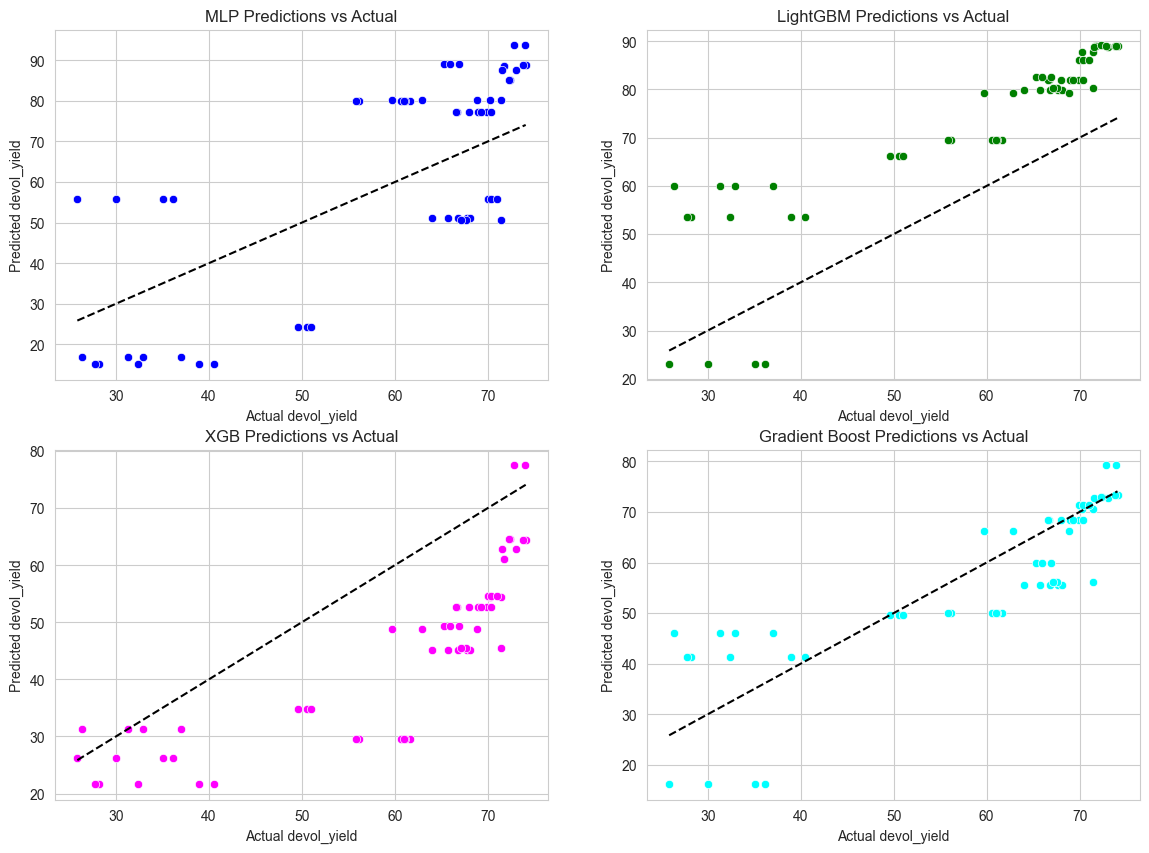

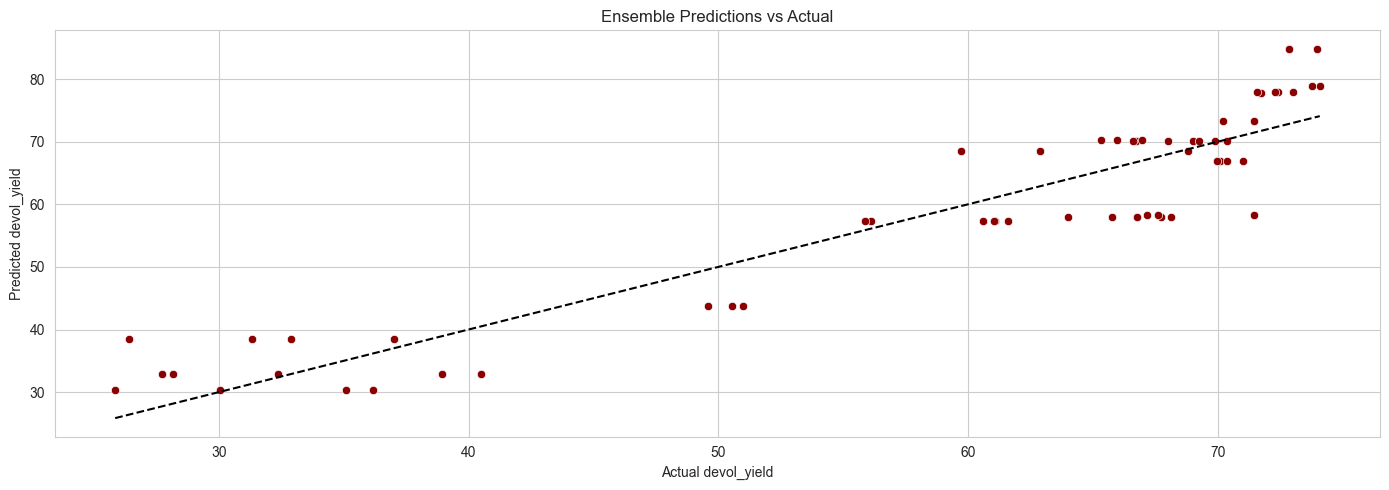

,Model,R2 Score,RMSE,MAE
0,MLP,-0.340788,17.742820,16.880841
1,LightGBM,-0.117894,16.201038,15.348566
2,XGBoost,-0.204226,16.814985,14.928644
3,Gradient Boosting,0.693785,8.479213,6.264608
4,Stacked Model,0.845912,6.014885,5.124839


In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from openpyxl.styles.builtins import title
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap
from sklearn.linear_model import Ridge


# Load models and preprocessing tools
mlp_model = joblib.load(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\models\best_mlp_model_torr_test.pkl")
lgb_model = joblib.load(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\models\best_lgb_model_torr_test.pkl")
xgb = joblib.load(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\models\best_xgb_model_torr_test.pkl")
gbr = joblib.load(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\models\best_gbr_model_torr_test.pkl")
scaler = joblib.load(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\models\scaler_lgb.pkl")

# Load and prepare test data (cellulose only)
data = pd.read_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\biomass_filtered.csv", delimiter=",")
print(data.columns.tolist())
test_data = data[data['fuel_type'] == 'torrwash']
X_test_mlp = test_data.drop(['Unnamed: 0','sample', 'fuel_type', 'fuel_category', 'devol_yield'], axis=1)
X_test_lgb = test_data.drop(['Unnamed: 0','sample', 'devol_yield'], axis=1)
y_test = test_data['devol_yield']

numerical_cols = X_test_lgb.select_dtypes(include=['int64', 'float64']).columns


X_test_scaled_numeric = pd.DataFrame(
    scaler.transform(X_test_lgb[numerical_cols]),
    columns=numerical_cols,
    index=X_test_lgb.index
)

# Get categorical columns (untouched)
categorical_cols = ['fuel_type', 'fuel_category']
X_test_categoricals = X_test_lgb[categorical_cols].copy()

# Ensure categorical type with correct categories
X_test_categoricals['fuel_type'] = pd.Categorical(
    X_test_categoricals['fuel_type'],
    categories=['biomass', 'plastic', 'coal', 'mix']
)
X_test_categoricals['fuel_category'] = pd.Categorical(
    X_test_categoricals['fuel_category'],
    categories=['biomass', 'plastic', 'coal', 'mix']  # adjust if your training set differs
)

# Final test set for LightGBM
X_test_scaled_lgb = pd.concat([X_test_scaled_numeric, X_test_categoricals], axis=1)
X_test_scaled_num = pd.DataFrame(
    scaler.transform(X_test_mlp),
    columns=X_test_mlp.columns,
    index=X_test_mlp.index
)

# Predictions
y_pred_mlp = mlp_model.predict(X_test_scaled_num.values)
y_pred_gbr = gbr.predict(X_test_scaled_num.values)
y_pred_lgb = lgb_model.predict(X_test_scaled_lgb)
y_pred_xgb = xgb.predict(X_test_scaled_num)

y_pred_stack = np.average([y_pred_mlp, y_pred_lgb, y_pred_gbr, y_pred_xgb], axis=0)

# Metrics
def get_metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

metrics_mlp = get_metrics(y_test, y_pred_mlp)
metrics_lgb = get_metrics(y_test, y_pred_lgb)
metrics_xgb = get_metrics(y_test, y_pred_xgb)
metrics_gbr = get_metrics(y_test, y_pred_gbr)
metrics_stack = get_metrics(y_test, y_pred_stack)

# Plot: Predictions vs Actual
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_mlp, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title("MLP Predictions vs Actual")
plt.xlabel("Actual devol_yield")
plt.ylabel("Predicted devol_yield")

plt.subplot(2, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_lgb, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title("LightGBM Predictions vs Actual")
plt.xlabel("Actual devol_yield")
plt.ylabel("Predicted devol_yield")

plt.subplot(2, 2, 3)
sns.scatterplot(x=y_test, y=y_pred_xgb, color="magenta")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title("XGB Predictions vs Actual")
plt.xlabel("Actual devol_yield")
plt.ylabel("Predicted devol_yield")

plt.subplot(2, 2, 4)
sns.scatterplot(x=y_test, y=y_pred_gbr, color="cyan")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title("Gradient Boost Predictions vs Actual")
plt.xlabel("Actual devol_yield")
plt.ylabel("Predicted devol_yield")

plt.figure(figsize=(14, 5))
sns.scatterplot(x=y_test, y=y_pred_stack, color="darkred")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title("Ensemble Predictions vs Actual")
plt.xlabel("Actual devol_yield")
plt.ylabel("Predicted devol_yield")

plt.tight_layout()
plt.show()

# Comparison Table
comparison_df = pd.DataFrame({
    "Model": ["MLP", "LightGBM", "XGBoost", "Gradient Boosting", "Stacked Model"],
    "R2 Score": [metrics_mlp["R2"], metrics_lgb["R2"], metrics_xgb["R2"], metrics_gbr["R2"], metrics_stack["R2"]],
    "RMSE": [metrics_mlp["RMSE"], metrics_lgb["RMSE"], metrics_xgb["RMSE"], metrics_gbr["RMSE"], metrics_stack["RMSE"]],
    "MAE": [metrics_mlp["MAE"], metrics_lgb["MAE"], metrics_xgb["MAE"], metrics_gbr["MAE"], metrics_stack["MAE"]],
})

comparison_df



In [164]:
pd.unique(data['fuel_type'])

array(['cellulose', 'digestate', 'hemicellulose', 'htc', 'lignin',
       'sewage', 'torrwash', 'wood'], dtype=object)

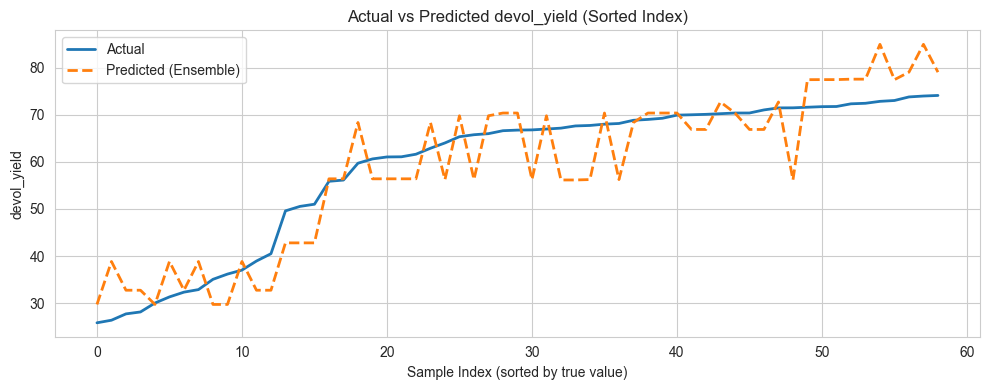

In [191]:
sorted_idx = np.argsort(y_test.values)
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[sorted_idx], label="Actual", linewidth=2)
plt.plot(y_pred_stack[sorted_idx], label="Predicted (Ensemble)", linestyle='--', linewidth=2)
plt.legend()
plt.title("Actual vs Predicted devol_yield (Sorted Index)")
plt.xlabel("Sample Index (sorted by true value)")
plt.ylabel("devol_yield")
plt.grid(True)
plt.tight_layout()
plt.show()


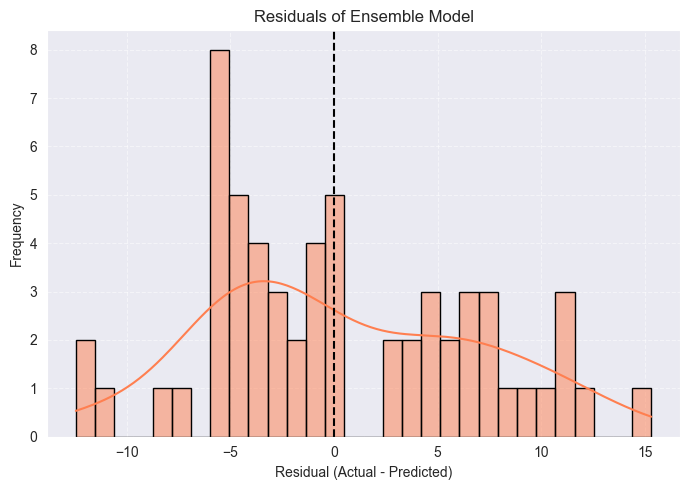

In [166]:
residuals_stack = y_test - y_pred_stack

plt.figure(figsize=(7, 5))
sns.histplot(residuals_stack, bins=30, kde=True, color="coral", edgecolor="black")
plt.axvline(0, color='k', linestyle='--')
plt.title("Residuals of Ensemble Model")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

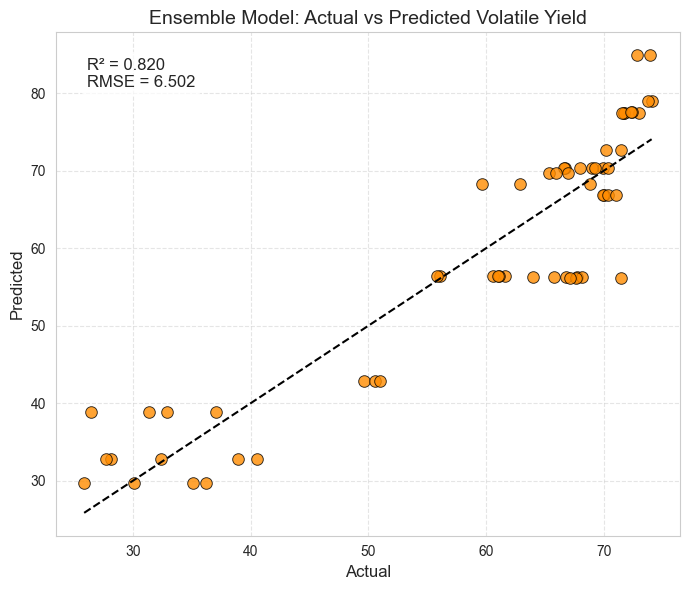

In [193]:
r2 = metrics_stack["R2"]
rmse = metrics_stack["RMSE"]

plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=y_pred_stack, color="darkorange", edgecolor="black", s=70, alpha=0.8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=1.5)
plt.title("Ensemble Model: Actual vs Predicted Volatile Yield", fontsize=14)
plt.xlabel("Actual", fontsize=12)
plt.ylabel("Predicted", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add metrics to the plot
plt.text(
    0.05, 0.95, f"R² = {r2:.3f}\nRMSE = {rmse:.3f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round')
)

plt.tight_layout()
plt.show()


C:\Users\demir\AppData\Local\Temp\ipykernel_20016\2757115131.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_devol_yield'] = y_pred_stack


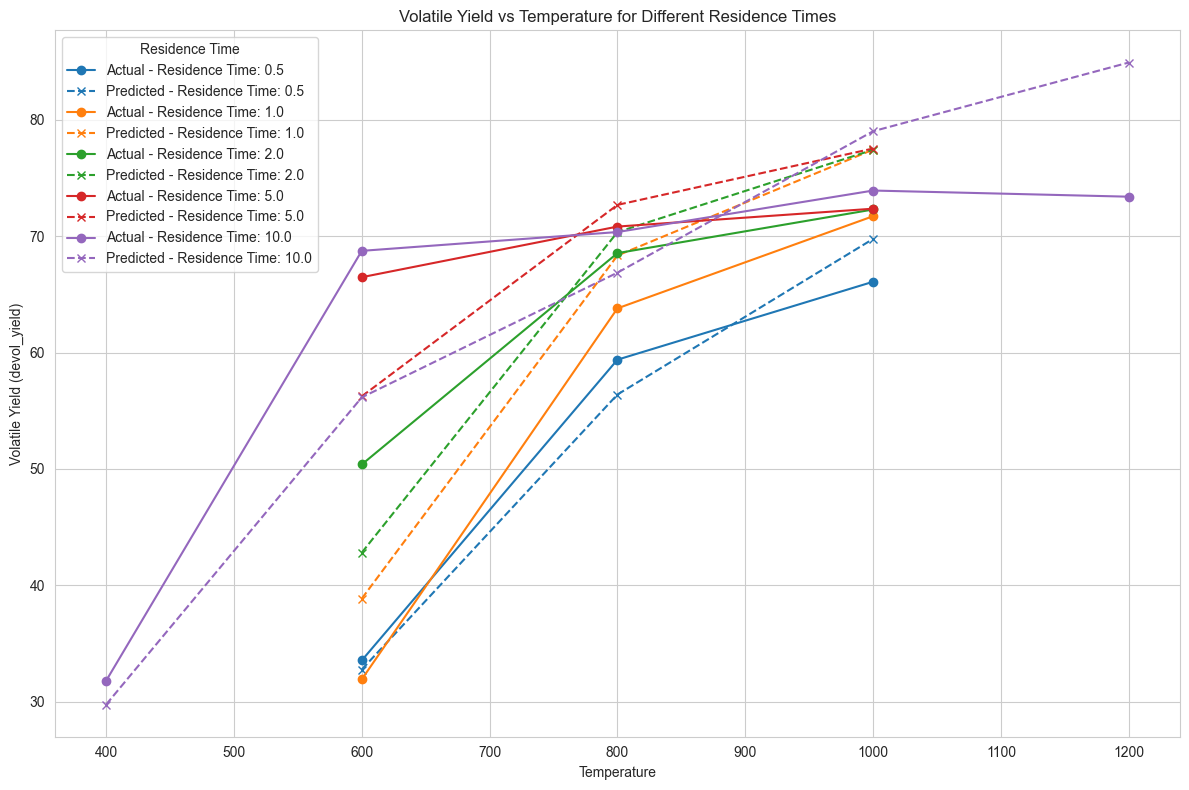

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is already loaded in 'test_data' with columns 'residence_time', 'temperature', and 'devol_yield'

# Get predictions from the stacked model (using the same preprocessing steps)
y_pred_stack = np.average([y_pred_mlp, y_pred_lgb, y_pred_gbr, y_pred_xgb], axis=0)

# Add predictions to the test data
test_data['predicted_devol_yield'] = y_pred_stack

# Group by 'residence_time' and 'temperature' to calculate the mean devol_yield and predicted devol_yield
mean_data = test_data.groupby(['residence_time', 'temperature'])['devol_yield'].mean().reset_index()
mean_pred_data = test_data.groupby(['residence_time', 'temperature'])['predicted_devol_yield'].mean().reset_index()

# Set up the plot
plt.figure(figsize=(12, 8))

# Define a color palette for residence_time
palette = sns.color_palette("tab10", n_colors=len(mean_data['residence_time'].unique()))

# Loop through each unique 'residence_time' and plot the mean relationship between temperature and devol_yield
for i, residence_time in enumerate(mean_data['residence_time'].unique()):
    # Filter the mean data for the specific residence_time
    subset = mean_data[mean_data['residence_time'] == residence_time]

    # Plot the relationship between temperature and mean devol_yield for the current residence_time (Actual)
    plt.plot(subset['temperature'], subset['devol_yield'], label=f"Actual - Residence Time: {residence_time}",
             linestyle='-', marker='o', markersize=6, color=palette[i])

    # Plot the relationship between temperature and predicted devol_yield for the current residence_time (Predicted)
    subset_pred = mean_pred_data[mean_pred_data['residence_time'] == residence_time]
    plt.plot(subset_pred['temperature'], subset_pred['predicted_devol_yield'], label=f"Predicted - Residence Time: {residence_time}",
             linestyle='--', marker='x', markersize=6, color=palette[i])

# Add labels and title
plt.xlabel('Temperature')
plt.ylabel('Volatile Yield (devol_yield)')
plt.title('Volatile Yield vs Temperature for Different Residence Times')

# Add a legend
plt.legend(title="Residence Time", loc='best')

# Show the plot
plt.tight_layout()
plt.show()


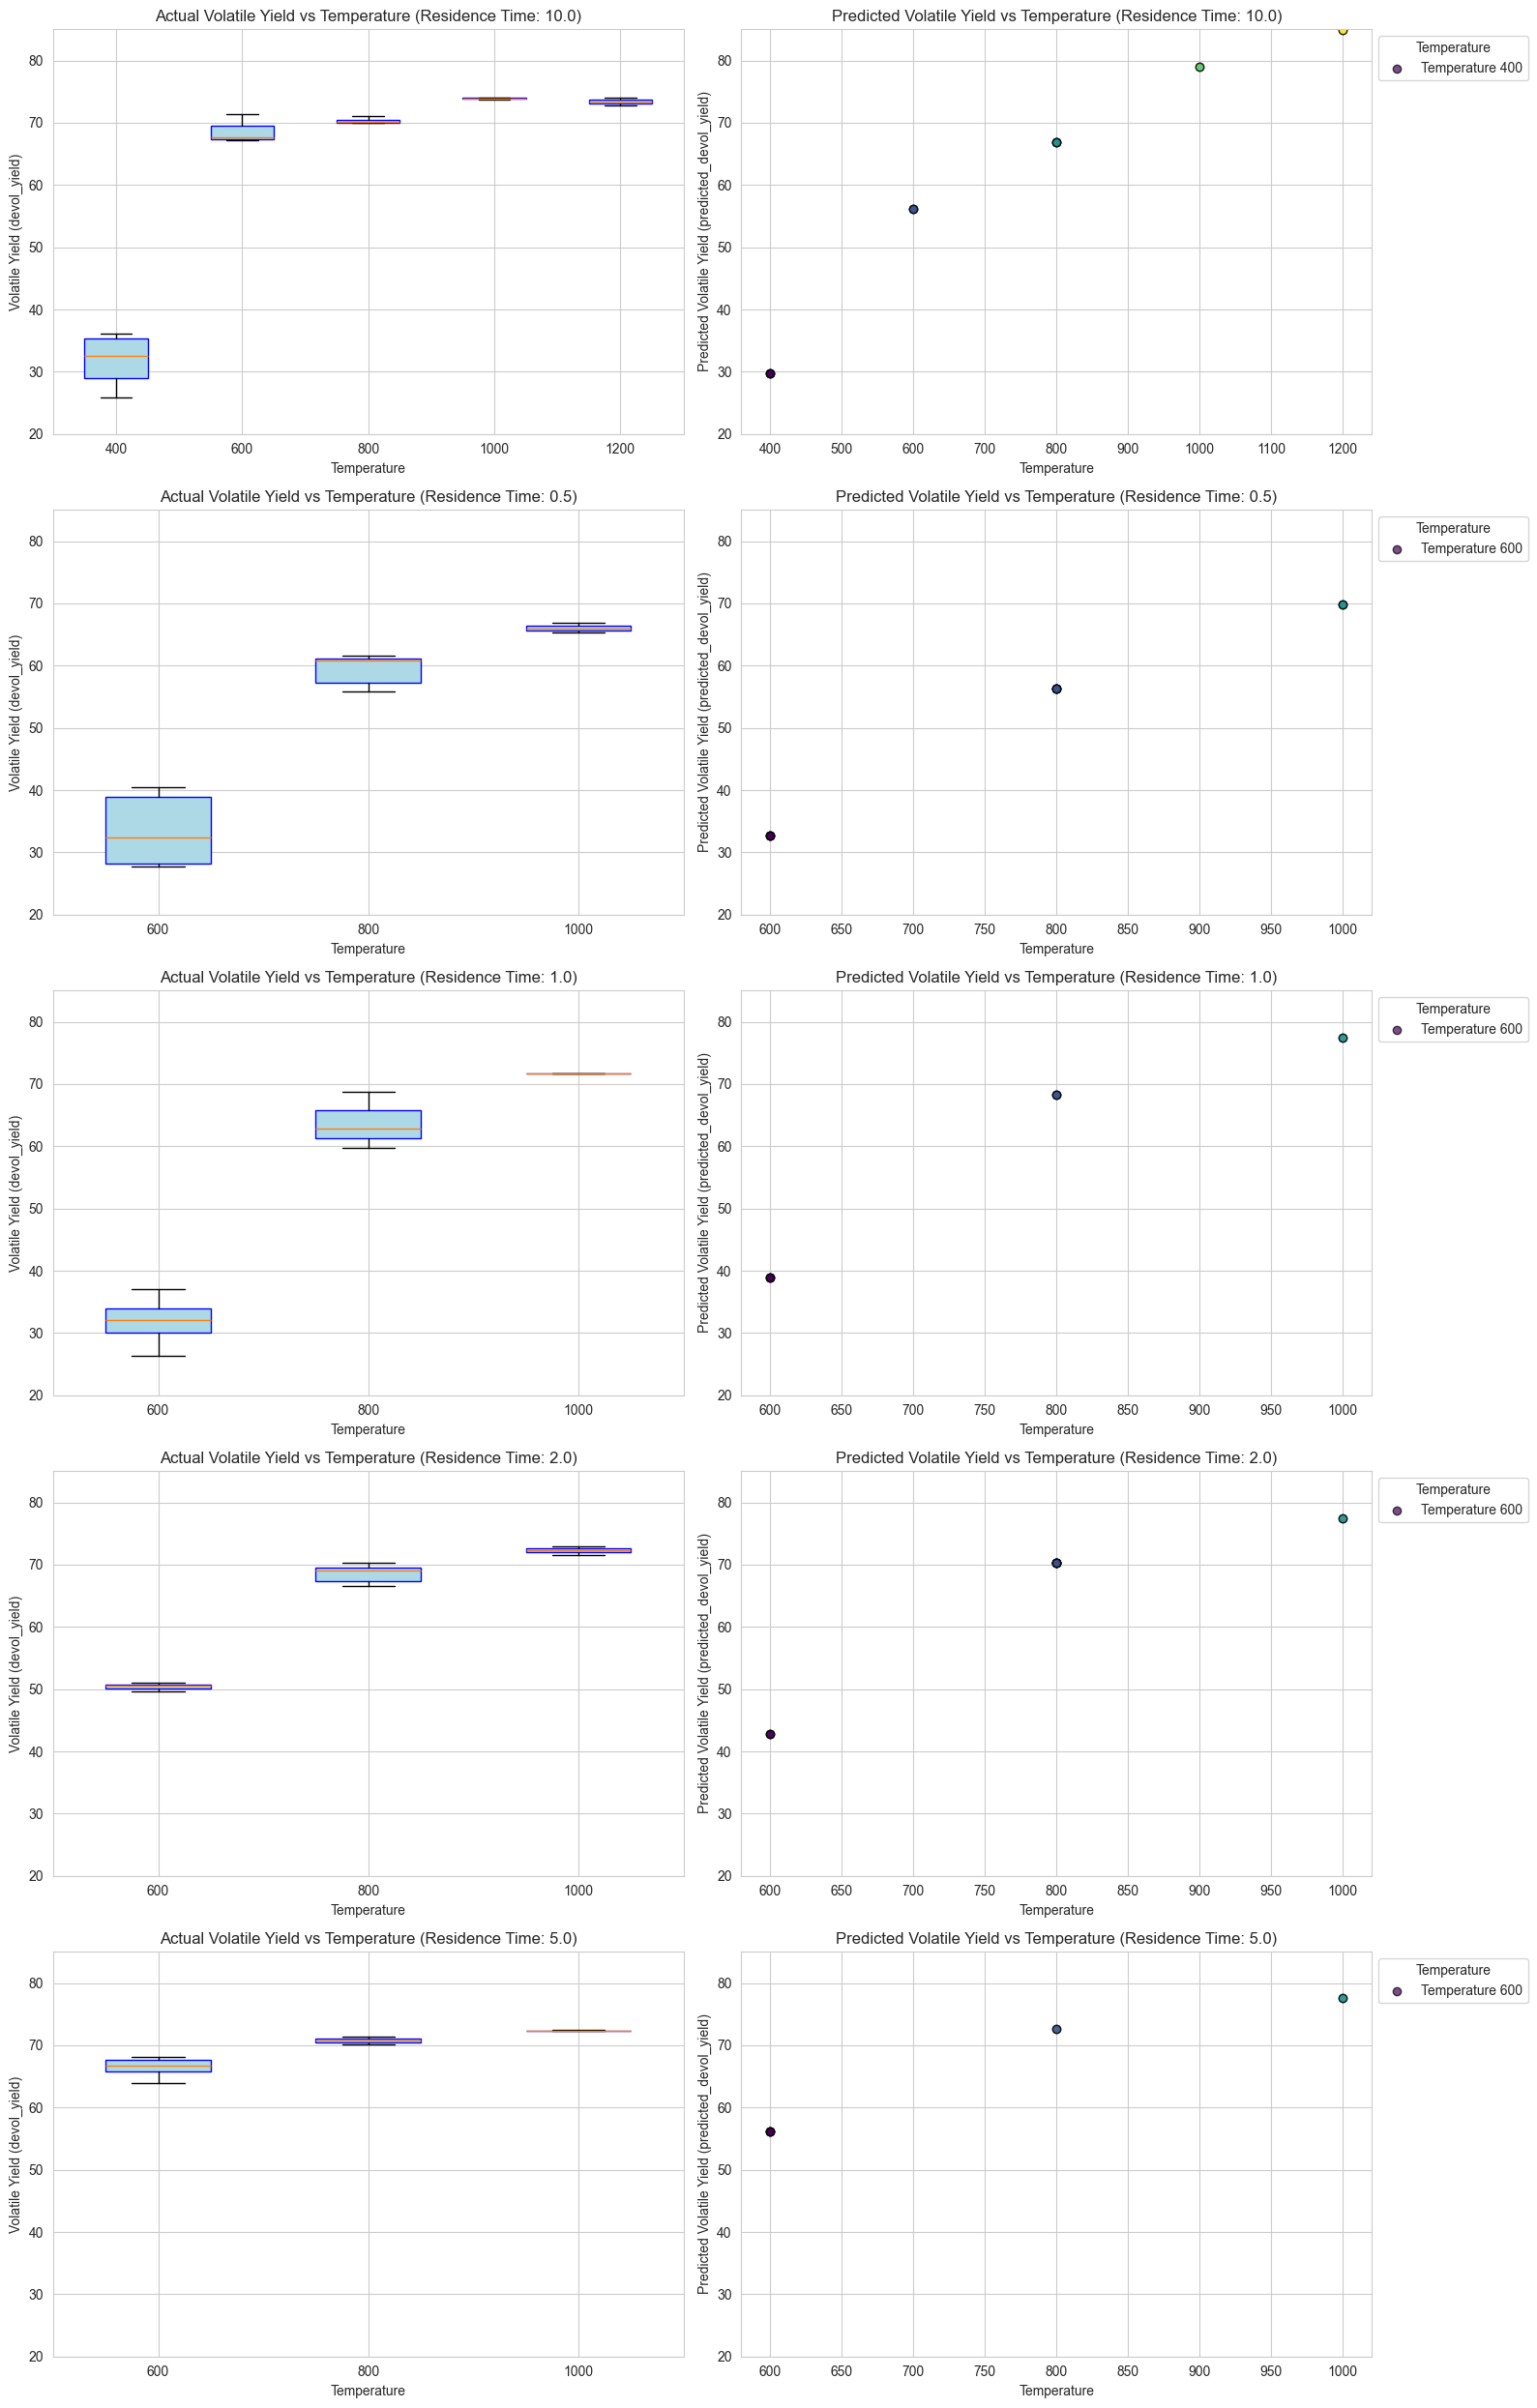

In [207]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique residence times
residence_times = test_data['residence_time'].unique()

# Create subplots for each residence_time value
fig, axes = plt.subplots(len(residence_times), 2, figsize=(16, 5 * len(residence_times)))

# Define a custom color palette for the temperature levels
colors = plt.cm.viridis(np.linspace(0, 1, len(test_data['temperature'].unique())))

# Loop over each unique residence_time and plot
for i, residence_time in enumerate(residence_times):
    # Filter the data for the current residence_time
    subset_actual = test_data[test_data['residence_time'] == residence_time]
    subset_predicted = test_data[test_data['residence_time'] == residence_time]

    # --- Plot Actual devol_yield as Box Plot ---
    # Create box plot for actual devol_yield
    axes[i, 0].boxplot([subset_actual[subset_actual['temperature'] == temp]['devol_yield'].values
                        for temp in subset_actual['temperature'].unique()],
                       positions=np.arange(len(subset_actual['temperature'].unique())),
                       widths=0.5, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'))
    axes[i, 0].set_xticks(np.arange(len(subset_actual['temperature'].unique())))
    axes[i, 0].set_xticklabels(subset_actual['temperature'].unique())
    axes[i, 0].set_title(f'Actual Volatile Yield vs Temperature (Residence Time: {residence_time})')
    axes[i, 0].set_xlabel('Temperature')
    axes[i, 0].set_ylabel('Volatile Yield (devol_yield)')
    axes[i, 0].set_ylim(20, 85)  # Set y-axis from 0 to 85

    # --- Plot Predicted devol_yield as Scatter Plot ---
    # Create scatter plot for predicted devol_yield
    for j, temp in enumerate(subset_predicted['temperature'].unique()):
        temp_data = subset_predicted[subset_predicted['temperature'] == temp]
        axes[i, 1].scatter([temp] * len(temp_data), temp_data['predicted_devol_yield'],
                           color=colors[j], label=f'Temperature {temp}' if j == 0 else "", alpha=0.7, edgecolors='k')

    axes[i, 1].set_title(f'Predicted Volatile Yield vs Temperature (Residence Time: {residence_time})')
    axes[i, 1].set_xlabel('Temperature')
    axes[i, 1].set_ylabel('Predicted Volatile Yield (predicted_devol_yield)')
    axes[i, 1].legend(title="Temperature", loc='upper left', bbox_to_anchor=(1, 1))
    axes[i, 1].set_ylim(20, 85)  # Set y-axis from 0 to 85

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
